In [9]:
# This notebook is inspired by scikit learn examples
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Albert Thomas <albert.thomas@telecom-paristech.fr>
# License: BSD 3 clause
# Link - https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py

# Anomaly Detection Comparison

This notebook demonstrates and compares various anomaly detection algorithms on different synthetic datasets. We'll explore the performance of algorithms like One-Class SVM, Isolation Forest, and Local Outlier Factor.

---

## 1. Importing Required Libraries

We'll start by importing the necessary libraries, including `matplotlib` for visualization, `numpy` for numerical operations, and various anomaly detection algorithms from `sklearn`.


In [1]:
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs, make_moons
from sklearn.ensemble import IsolationForest
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline

# Set matplotlib style for better visuals
matplotlib.rcParams["contour.negative_linestyle"] = "solid"


## 2. Dataset and Algorithm Configuration

We'll define the number of samples, the fraction of outliers, and various anomaly detection algorithms that we will compare. We'll also create synthetic datasets with different characteristics.


In [6]:
# Constants
N_SAMPLES = 1000
OUTLIERS_FRACTION = 0.20
N_OUTLIERS = int(OUTLIERS_FRACTION * N_SAMPLES)
N_INLIERS = N_SAMPLES - N_OUTLIERS
RANDOM_STATE = 42

def initialize_algorithms(outliers_fraction, random_state):
    """Initializes and returns a list of anomaly detection algorithms."""
    return [
        ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction, random_state=random_state)),
        ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
        (
            "One-Class SVM (SGD)",
            make_pipeline(
                Nystroem(gamma=0.1, random_state=random_state, n_components=150),
                SGDOneClassSVM(
                    nu=outliers_fraction,
                    shuffle=True,
                    fit_intercept=True,
                    random_state=random_state,
                    tol=1e-6,
                ),
            ),
        ),
        ("Isolation Forest", IsolationForest(contamination=outliers_fraction, random_state=random_state)),
        ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction)),
    ]

## 3. Generating Synthetic Datasets

We will create several synthetic datasets using `make_blobs` and `make_moons` functions, each with distinct patterns to test the robustness of the anomaly detection algorithms.


In [3]:
def generate_datasets(n_inliers, random_state):
    """Generates synthetic datasets for anomaly detection."""
    blobs_params = dict(random_state=random_state, n_samples=n_inliers, n_features=2)
    datasets = [
        make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
        make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
        make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
        4.0 * (make_moons(n_samples=N_SAMPLES, noise=0.05, random_state=random_state)[0] - np.array([0.5, 0.25])),
        14.0 * (np.random.RandomState(random_state).rand(N_SAMPLES, 2) - 0.5),
    ]
    return datasets

## 4. Visualizing the Results

We'll plot the datasets along with the results from each anomaly detection algorithm. The decision boundaries, computation time, and predicted outliers will be displayed for each combination of dataset and algorithm.


In [4]:
def add_outliers_to_dataset(X, n_outliers, low=-6, high=6, random_state=None):
    """Adds uniform outliers to the dataset."""
    rng = np.random.RandomState(random_state)
    return np.concatenate([X, rng.uniform(low=low, high=high, size=(n_outliers, 2))], axis=0)

def plot_anomaly_detection_results(datasets, anomaly_algorithms):
    """Plots the results of anomaly detection algorithms on various datasets."""
    xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))
    plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
    plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01)

    plot_num = 1
    for i_dataset, X in enumerate(datasets):
        X = add_outliers_to_dataset(X, N_OUTLIERS, random_state=RANDOM_STATE)
        
        for name, algorithm in anomaly_algorithms:
            t0 = time.time()
            try:
                algorithm.fit(X)
            except Exception as e:
                print(f"Error fitting {name}: {e}")
                continue
            t1 = time.time()
            
            plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
            if i_dataset == 0:
                plt.title(name, size=18)

            # Predict and plot results
            try:
                if name == "Local Outlier Factor":
                    y_pred = algorithm.fit_predict(X)
                else:
                    y_pred = algorithm.fit(X).predict(X)

                if name != "Local Outlier Factor":  # LOF does not implement predict
                    Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
                    Z = Z.reshape(xx.shape)
                    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

                # Scatter plot of the data points
                colors = np.array(["#377eb8", "#ff7f00"])
                plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

                plt.xlim(-7, 7)
                plt.ylim(-7, 7)
                plt.xticks(())
                plt.yticks(())

                # Display computation time
                plt.text(
                    0.99,
                    0.01,
                    ("%.2fs" % (t1 - t0)).lstrip("0"),
                    transform=plt.gca().transAxes,
                    size=15,
                    horizontalalignment="right",
                )
            except Exception as e:
                print(f"Error during prediction/plotting for {name}: {e}")

            plot_num += 1

    plt.show()

## 5. Conclusion

This notebook visually demonstrates the performance of different anomaly detection algorithms on various datasets. The decision boundaries and computation times vary significantly across algorithms and datasets, highlighting the importance of selecting the appropriate method based on the data characteristics.


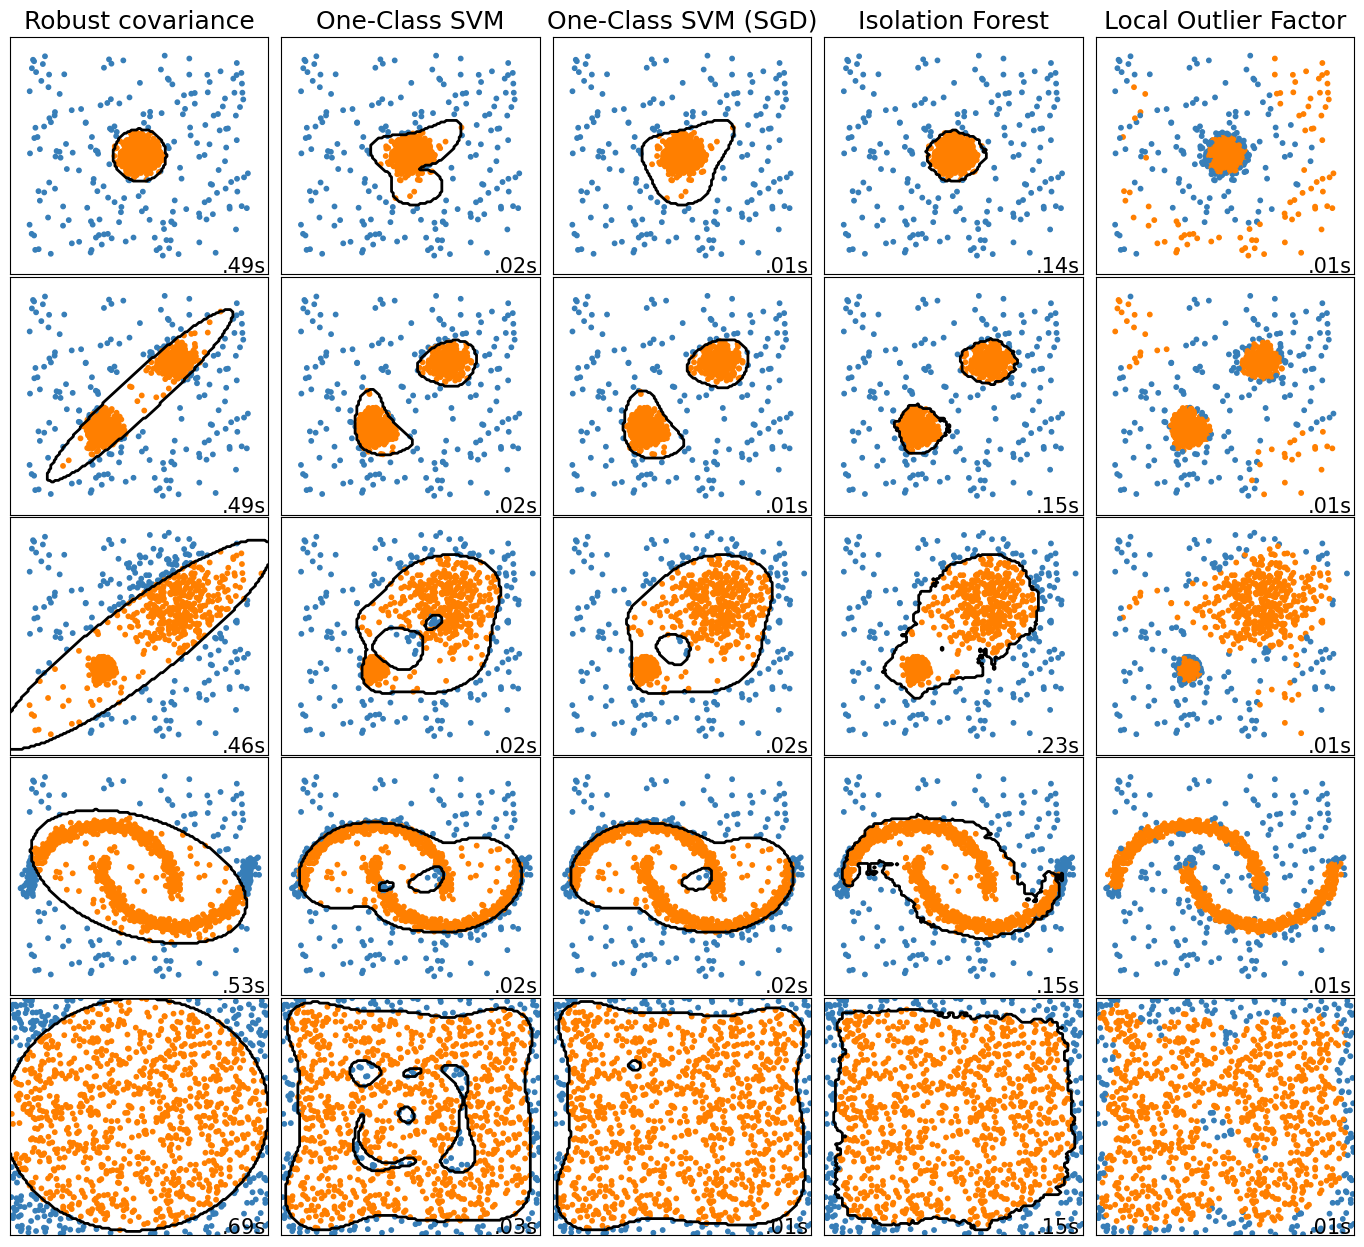

In [7]:
def main():
    """Main function to run the anomaly detection comparison."""
    datasets = generate_datasets(N_INLIERS, RANDOM_STATE)
    anomaly_algorithms = initialize_algorithms(OUTLIERS_FRACTION, RANDOM_STATE)
    plot_anomaly_detection_results(datasets, anomaly_algorithms)

if __name__ == "__main__":
    main()

## Takeaway

This example demonstrates how various anomaly detection algorithms perform on 2D datasets with high-density regions, including 20% random noise.

The OneClassSVM, sensitive to outliers, is better for novelty detection in clean datasets. The `SGDOneClassSVM`, using stochastic gradient descent and kernel approximation, scales better with larger datasets while providing similar results. `EllipticEnvelope`, assuming Gaussian data, works well for unimodal distributions but struggles with multimodal data.

`IsolationForest` and `Local Outlier Factor (LOF)` handle multimodal data effectively, with LOF excelling when data modes differ in density due to its local comparison approach. For uniformly distributed data, most algorithms perform well, though OneClassSVM may overfit slightly.

These examples offer insights into algorithm behavior, though outcomes may vary with high-dimensional data. Parameter tuning is crucial, especially in unsupervised settings.